# Part 3: Deploying as a FaaS

## 1. Verifying our model

The first part of this milestone will consist in verifying our model. With this, we'll be sure that we have everything that we need to run our model in a remote environment like a FaaS, and that we'll be able to predict new text with it.

### Download corpuses

Since we won't be doing any model-training in this step, we don't need the 'movie_reviews' corpus. However, we will still need to extract features from our input before each prediction, so we make sure 'punkt' and 'stopwords' are available for tokenization and stopword-removal. If you added any other corpuses in Part 2, consider whether they'll be needed in the prediction step.

In [ ]:
from nltk import download

download('punkt')
download('stopwords')

### Define feature extractor and bag-of-words converter

IMPORTANT: your predictions will only work properly if you use **the same** feature extractor that you trained your model with, so copy your updated `extract_features` method over from Part 2, replacing the method below


In [ ]:
def extract_features(document):
    # YOUR IMPLEMENTATION HERE
    # Make sure that the code in extract_features is the same
    # that you used in the training phase
    pass

# Example:
print(extract_features("Hello world, corpuses calling!"))

### Import your pickled model file (non-Colab version)

In Part 2, we saved the trained model as "sa_classifier.pickle". Now we'll unpickle that file to get it back into memory. Either copy that file into the same folder as this notebook ("part3"), or adjust the path below to "../part2/sa_classifier.pickle" so it reads the file from the folder where it was saved.

In [ ]:
import pickle
import sys

if not 'google.colab' in sys.modules:
    model_file = open('sa_classifier.pickle', 'rb')
    model = pickle.load(model_file)
    model_file.close()

### Import your pickled model file (Colab version)

If you're running this notebook on Colab, we need to retrieve the pickled model from [Google Drive](https://drive.google.com) before we can unpickle it. This code looks for "sa_classifier.pickle" in a folder called "Colab Output"; if you have moved the file elsewhere, change the path below.

In [ ]:
import pickle
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    !ls '/content/gdrive/My Drive/Colab Output'
    model_file = open('/content/gdrive/My Drive/Colab Output/sa_classifier.pickle','rb')
    model = pickle.load(model_file)
    model_file.close()
    print('Model loaded from /content/gdrive/My Drive/Colab Output')

### Define a method for prediction

In the prediction step, we'll be taking a single piece of text input and asking the model to classify it. Models need the input for the prediction step to have the same format as the data provided during training -- so we must tokenize the input, run the same `extract_features` method that we used during training, and convert it to a bag of words before sending it to the model's `classify` method.

Note: if you have (from Part 2) changed your `extract_features` method to accept the full text instead of a tokenized list, then you can omit the tokenization step here.

In [ ]:
def get_sentiment(review):
    words = extract_features(review)
    words = bag_of_words(words)
    return model.classify(words)

### Run a prediction

Test out your `get_sentiment` method on some sample inputs of your own devising: try altering the two reviews below and see how your model performs. It won't be 100% correct, and we're mostly just looking to see that it is able to run at all, but if it sems to *always* be wrong, that may indicate you've missed a critical step above (e.g. you haven't copied over all the changes to your feature extractor from Part 2, or you've loaded the wrong model file, or provided un-tokenized text when a list of words was expected).

In [ ]:
positive_review = 'This movie is amazing, with witty dialog and beautiful shots.'
print('positive_review: '+get_sentiment(positive_review))

negative_review = 'I hated everything about this unimaginitive mess. Two thumbs down!'
print('negative_review: '+get_sentiment(negative_review))

---

## 2. Preparing the FaaS environment

The next part consists in preparing the environment that we will deploy to our FaaS. All the code that our model will use needs to be deployed, which means that we will have to prepare not only our function, but also its dependencies!

For simplicity, the example will assume we want to run our model in AWS Lambda

### Generating a requirements.txt

The first step consists in specifying our dependencies in a `requirements.txt` file. This file is used for specifying what python packages are required to run the project you are looking at.

There are multiple ways of generating this file, depending on which package manager you are using. Here you can find an example for some of the most common tools (_uncomment the command that corresponds the one you're using_)

In [ ]:
# If you use a virtualenv, or don't use any dependency manager at all
# !pip freeze > requirements.txt

# If you use Anaconda
# !conda list -e > requirements.txt

# If you use Pipenv
# !pipenv lock --requirements > requirements.txt

# If you use poetry
# !poetry export -f requirements.txt -o requirements.txt

### Installing the dependencies

The next step consists in installing all the dependencies in a specific directory. This will allow us to have all of them together somewhere we know.

In [ ]:
!mkdir dependencies
!pip install --requirement requirements.txt --target ./deployment-files --ignore-installed

### Upload the model to an S3 bucket

Lambda functions have a size limitation of 250MB. Our Sentiment Analysis model can be significantly big, which means that we might trespass that threshold when we consider the dependencies and our own function code.

To prevent that problem, we will upload the model to S3 as a separate file, which later we will load from our code. You can find a tutorial on uploading files to S3 on the following documentation link:

https://docs.aws.amazon.com/AmazonS3/latest/userguide/upload-objects.html

**NOTE:** _you need to make sure that the model file will be accessible by your Lambda function. You can do that either by attaching to it an IAM Role that gives permissions to the bucket ([additional info here](https://aws.amazon.com/blogs/security/writing-iam-policies-how-to-grant-access-to-an-amazon-s3-bucket/)) or by enabling public access to the bucket, but that could result in security issues so don't do it unless you are completely sure of the implications._

### Creating our function code

Now, we will work on the code that our FaaS function will run whenever it is called. As mentioned before, the examples are focused on AWS Lambda, so if you plan to use a different provider make sure that you adapt the code to how it works

We will create a file called `main.py` with the following code

**NOTE: make sure that you add the correct values for the S3 bucket and the file name!**

In [ ]:
import json
import pickle
import re
from string import punctuation

import boto3
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.util import everygrams

# Downloading the datasets our model needs
# You need to specify the download path because not
# all paths are available in Lambda
nltk.data.path.append("/tmp")
nltk.download("punkt", download_dir = "/tmp")
nltk.download("stopwords", download_dir = "/tmp")
nltk.download('wordnet', download_dir = "/tmp")

# Replace these values with your own bucket and file information
S3_BUCKET_NAME = 'YOUR_BUCKET_NAME_HERE'
S3_FILE_NAME = 'YOUR_FILE_NAME_HERE'

# Download your model from S3 and use pickle to load it
# model = <COMPLETE_THIS>


stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def bag_of_words(words):                                                                                                                                                                                       
    bag = {}                                                                                                                                                                                                   
    for w in words:                                                                                                                                                                                            
        bag[w] = bag.get(w,0)+1                                                                                                                                                                                
    return bag

def is_useful_word(word):
    return (word not in stopwords_eng) and (word not in punctuation)

def extract_features(document):
    words = word_tokenize(document)
    lemmas = [str(lemmatizer.lemmatize(w)) for w in words if is_useful_word(w)]
    document = " ".join(lemmas)
    document = document.lower()
    document = re.sub(r'[^a-zA-Z0-9\s]', ' ', document)
    words = [w for w in document.split(" ") if w != "" and is_useful_word(w)]
    return [str('_'.join(ngram)) for ngram in list(everygrams(words, max_len=3))]

def get_sentiment(review):
    words = extract_features(review)
    words = bag_of_words(words)
    return model.classify(words)

def handler(event, context):
    review = event['body']
    predicted_sentiment = get_sentiment(review)
    return { 'statusCode': 200, 'body': json.dumps(predicted_sentiment) }


### Packaging everything

Finally, we will package both our code and its dependencies in a .zip file. To do so, and assuming that you stored everything like in the previous steps, run the following commands:

In [ ]:
# Moving our code to the folder we'll deploy
!mv main.py deployment-files

# Packing the third-party dependencies
!cd deployment-files
!zip -r deployment-files.zip ./deployment-files/*

---

## 3. Deploying our code

Finally, we will deploy our code to our FaaS platform. As mentioned before, the following examples will be using AWS Lambda, but any other FaaS platform would work too.

Now that you have your zip package, you can start by creating a Lambda function and load your code into it. You have detailed steps in the following documentation page:

https://docs.aws.amazon.com/lambda/latest/dg/configuration-function-zip.html

## Additional configuration

Now that the code is deployed, there are still a few steps we need to take before being able to use our model. These steps are required to make sure our Lambda function will have enough capacity to load the model and use it

**Disclaimer**: _increasing our Lambda function's capacity will increase the cost of running it. At the moment of writing this, the AWS Lambda free tier includes one million free requests per month and 400,000 GB-seconds of compute time per month, which is more than enough for the project. However, if you plan to use this in a production project or run it very frequently, make sure that you check [Lambda's pricing page](https://aws.amazon.com/lambda/pricing/) and confirm that the cost will be reasonable for what you expect_

### 1) Update Lambda timeout

We want to be sure that our Lambda will have enough time to download the model, load it and use it to make a prediction. Lambda functions have a default timeout of 3 seconds, which is probably too little time. We are going to set it to 15 minutes, the max possible value. We expect to need way less than that, but some extra headroom can always be helpful

To configure the value, log into the AWS Console, go to Lambda and select your function.

After the "Function overview" section, you will see multiple tabs. Select "Configuration" and then click on "Edit" on "General configuration". There, set the timeout to `15 minutes 0 seconds`

### 2) Increase Lambda memory

If the model takes 250 MB, we can't run with a 128MB Lambda; we are going to need significantly more than that to ensure that the processing completes successfully

To make sure that we have enough capacity, we will set it to `5120 MB`. As with the timeout, we expect to need less than that, but with this one we will know for sure that the function will work

We can edit the memory in the "General configuration section" too - so you just need to follow the same steps as before

## Testing our function

Now, it's finally time to test our model! To keep things as simple as possible, we will test it manually in the AWS Console

Go to your Lambda function on the AWS Console and select the "Test" tab, next to the "Configuration" option we used before. Select "New event" and choose a template (which one doesn't matter, because we will override it completely)

Give the event a name and use the following content:

```json
{
  "body": "this is a very great movie this is wonderful amazing really good"
}
```

Then, click the "Test" button, and enjoy the result! Finally, your sentiment analysis model is running online! Great job!

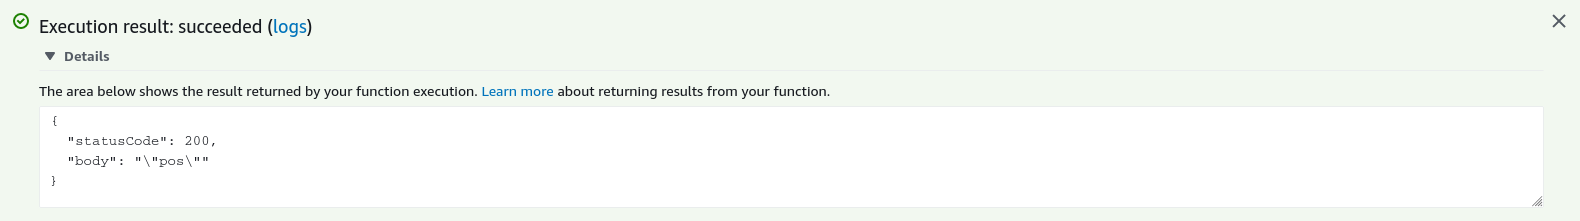